### Import required libraries

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

#### Setting-up global variables

In [2]:
CAM_MODE = False

cam = cv2.VideoCapture(0)

Image_path = 'Testimg_2.jpg'

img = cv2.imread(Image_path)
print(img.shape)

img_final = None

# 2480 x 3508   // 3.44 =>> 720 x 1020
width, height = 640, 900

Threshold1, Threshold2 = 0, 0

(1280, 971, 3)


#### __Defining functions for further utilization__

In [3]:
def nothing(x):
    pass

#============================================================
def biggestContour(contours):
    """Used to find the biggest contour based on contour-area, length and approx-Shape"""
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 5000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
    return biggest

#============================================================
def reorder(myPoints):
    """Reorder of contour end-points,
    such that we have points sorted on Top->Butoom and Left->Right
    """
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    #=-=-=-=-=-=-=--=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
 
    return myPointsNew
 
#============================================================

### __Defining functions for image-segementation(extraction)__

In [4]:
def Extract_from_image():
    global img, Threshold1, Threshold2, img_final
    #============================================================
    # Create Trackbars for varible Threshold values
    cv2.namedWindow("Trackbars")
    cv2.resizeWindow("Trackbars", 360, 240)
    cv2.createTrackbar("Threshold1", "Trackbars", 80,255, nothing)
    cv2.createTrackbar("Threshold2", "Trackbars", 200, 255, nothing)
    #============================================================
    while True:
        if CAM_MODE: img = cam.read()
        #========================================================
        # Resizing the image
        img = cv2.resize(img, (width, height))
        #========================================================
        # Copies of image for process-result-comparison
        img_copy = img.copy()
        img_final = img.copy()
        #========================================================
        # Converted image into gray scale
        Gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Blurred the gray-image using Gaussin-function
        Gray_blur = cv2.GaussianBlur(Gray,(5,5), 1)
        #========================================================
        # Getting the values for Trackbars 
        Threshold1 = cv2.getTrackbarPos("Threshold1", "Trackbars")
        Threshold2 = cv2.getTrackbarPos("Threshold2", "Trackbars")
        # Detecting edges using Canny-Edge-detection with user give threshold values
        Edges = cv2.Canny(Gray_blur,Threshold1,Threshold2)
        #========================================================
        # Applying Closing Operation on the Edges-detected
        # Closing operation => Dilation followed by Erosion
        # --------------------------
        # Creating kernl of size 5x5
        kernel = np.ones((5, 5))
        # -- Method-1 --
        # img_dialet = cv2.dilate(Edges, kernel, iterations=2) # APPLY DILATION
        # Final_edge = cv2.erode(img_dialet, kernel, iterations=1)  # APPLY EROSION

        # -- Method-2 --
        Final_edge = cv2.morphologyEx(Edges, cv2.MORPH_CLOSE, kernel)
        #========================================================
        # Finding Contours in the 'Edge'-image
        contour, heirarchy = cv2.findContours(Final_edge , cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        
        # FIND THE BIGGEST CONTOUR
        biggest = biggestContour(contour)

        # if there is contour in the image
        if biggest.size != 0:
            # if there is contour in the image, then sort the contours based on Top-down approach
            biggest = reorder(biggest)
            # DRAW THE BIGGEST CONTOUR
            cv2.drawContours(img_copy, biggest, -1, (0, 255, 0), 20)
            #=====================================================
            # Apply Projective-Transformation on the image for the given biggest contour
            # -- Corner Points of the image from which to extract --
            pts1 = np.float32(biggest) 
            # -- Final Points (Coordinate) to which Extacte-Contour to set --
            pts2 = np.float32([[0, 0],[width, 0], [0, height],[width, height]]) 
            # -- Get Projective Transformation Matrix --
            matrix = cv2.getPerspectiveTransform(pts1, pts2)
            # -- Apply Projectie-Transformat --
            img_final = cv2.warpPerspective(img, matrix, (width, height))
            img_final = cv2.resize(img_final,(width, height))
        #========================================================
        cv2.imshow("Original", img_copy)
        cv2.imshow("Final Image", img_final)
        cv2.imshow("Object Edge", Edges)
        #========================================================
        if cv2.waitKey(1) == ord('q'):
            break
        
    cv2.destroyAllWindows()

In [5]:
Extract_from_image()

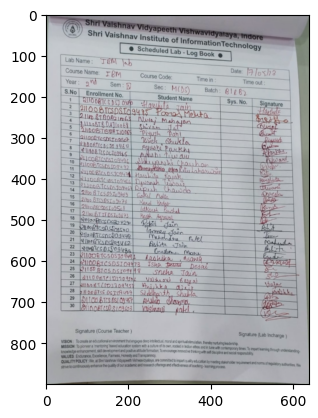

In [6]:
plt.imshow(img_final)

In [7]:
cv2.imwrite('Img_extarct_output.jpg',img_final)

True